In [ ]:
# To install matlab, run pip install matlab
# To install matlab engine, run pip install 'matlabengine == 9.13.7'

import numpy as np
import torch
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from IPython.display import display
%matplotlib inline

# import os, sys
# root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
# sys.path.append(root_path)

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
os.makedirs("estimates", exist_ok=True)

from Models import BG



c:\Users\yoshi\OneDrive\Desktop\Research\Multivariate FIR\Multivariate-Investments-1\BG_Modeling
cuda is available:  True
GPU name:  NVIDIA GeForce RTX 4070 Laptop GPU


In [2]:
# 1) Build one BG instance
bg = BG(N=2**14, B=300000,batch_size=256)
bg.all_params = np.load("estimates/spy/spy_theta_500_BT_False_500_BT_True.npy", allow_pickle=True)
theta_spy = bg.all_params
theta_batch = torch.tensor(bg.all_params, dtype=torch.float32).to('cuda')
# Split s_batch into CUDA batches
if np.isnan(bg.batch_losses).all():
    for t0 in range(0, bg.T, bg.batch_size):
        t1 = min(t0 + bg.batch_size, bg.T)

        # Get theta_batch
        theta_batch_t = theta_batch[t0:t1]
        s_batch = bg.s_batch[t0:t1]  # narrow s_batch to batch window
        Pi_batch = bg.Pi_target_torch[t0:t1]  # narrow Pi_target to batch window

        with torch.no_grad():
            per_day_loss = bg.quantile_loss_AD(theta_batch_t, s_batch, Pi_batch, return_per_day=True)
        bg.batch_losses[t0:t1] = per_day_loss.cpu().numpy()

print("Final theta shape:", theta_spy.shape)
print("Example SPY params at t=150:", theta_spy[0])

Final theta shape: (4330, 4)
Example SPY params at t=150: [0.00216513 1.54482508 0.00463692 0.63321126]


In [3]:
maxT = theta_spy.shape[0]
print("Example SPY params at t=150:", theta_spy[:min(5, maxT)])


Example SPY params at t=150: [[0.00216513 1.54482508 0.00463692 0.63321126]
 [0.00215324 1.54474294 0.00470125 0.63331127]
 [0.00216253 1.54480386 0.0045908  0.63324624]
 [0.00216589 1.54481936 0.00459935 0.63318288]
 [0.00215443 1.54474366 0.00468777 0.63330191]]


Worst batch index: 1968
3 figures generated.


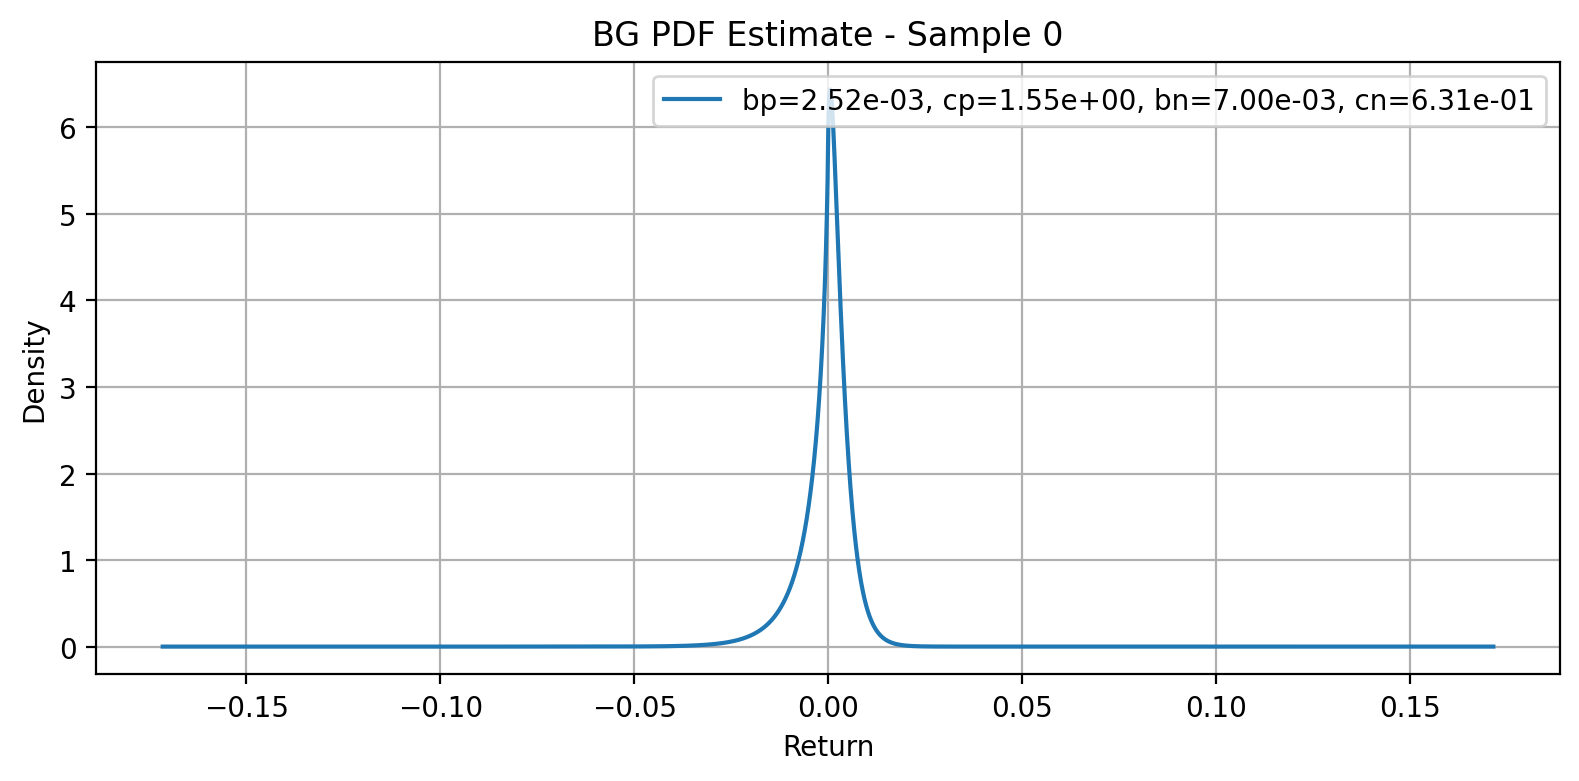

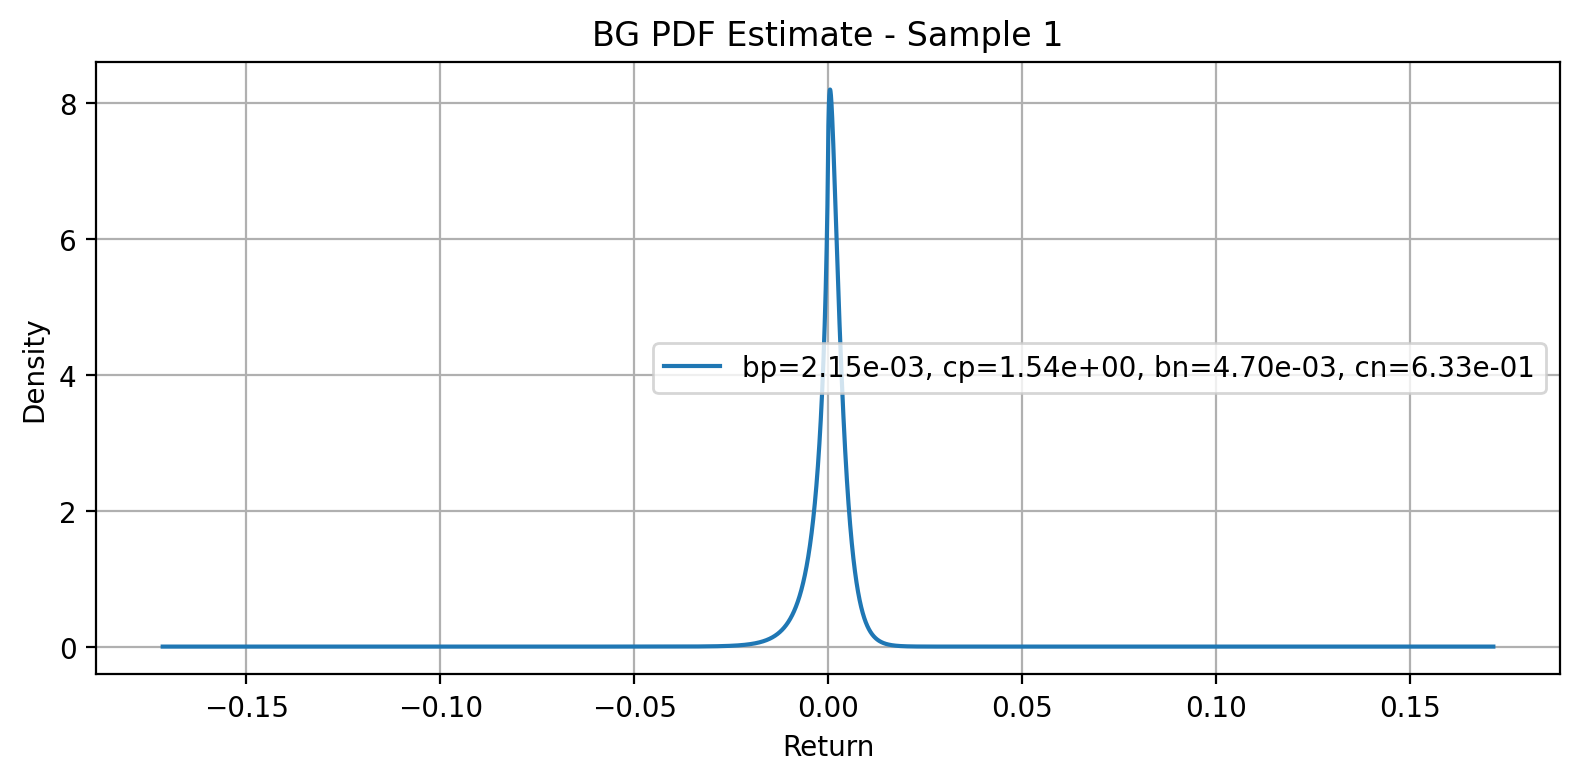

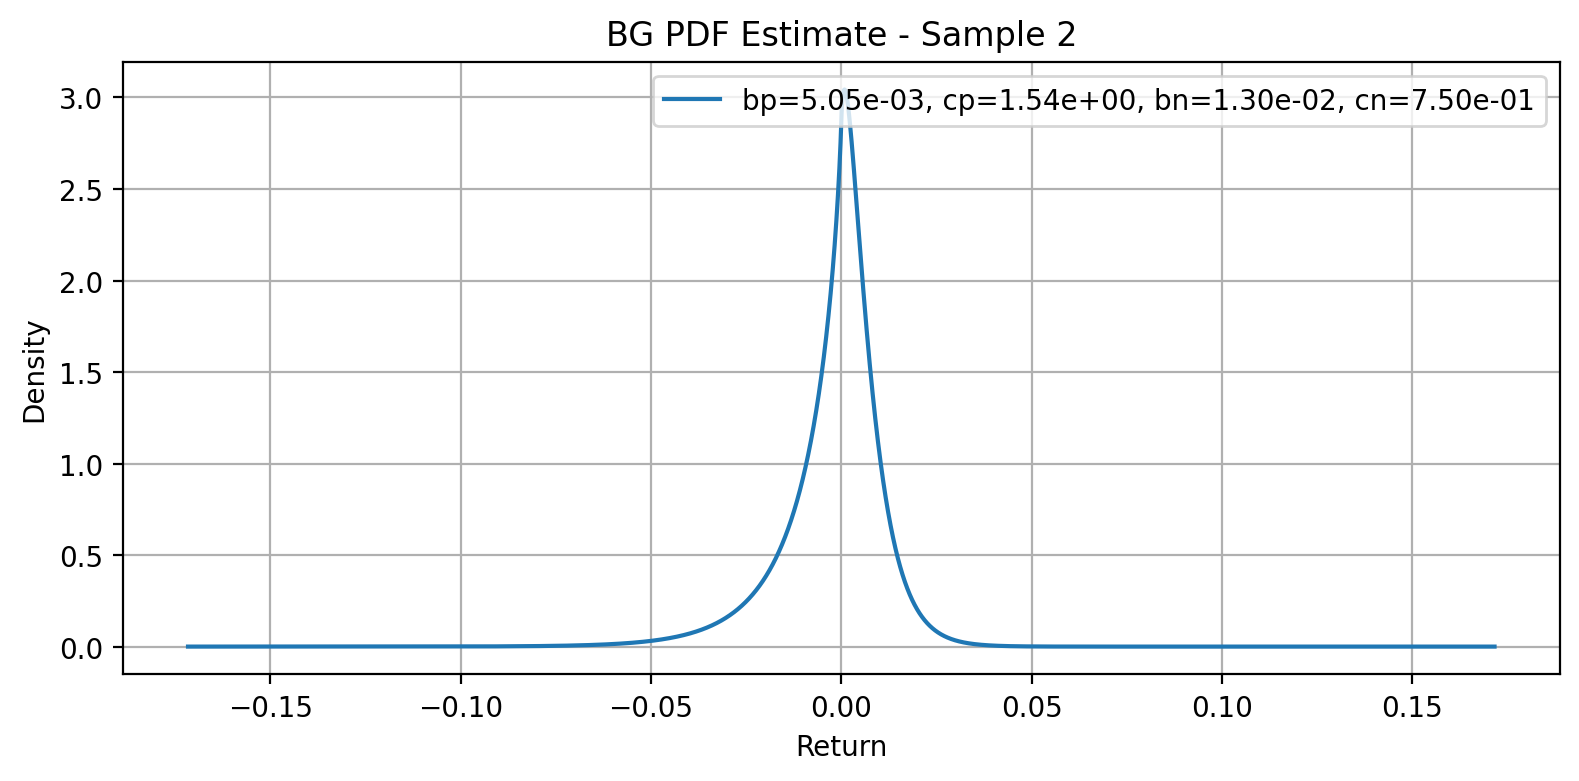

In [4]:
idx_worst = bg.batch_losses.argmax()+bg.window
print("Worst batch index:", idx_worst)

theta_batch = torch.tensor(bg.all_params[[idx_worst,1,257]], dtype=torch.float32).to('cuda')
pdfs = bg.pdf(theta_batch)  # Expected shape: [5, 4096]
figures = bg.plot_bg_pdfs(theta_batch, pdfs, returnfig=True)
print(len(figures), "figures generated.")
for fig in figures:
    display(fig)

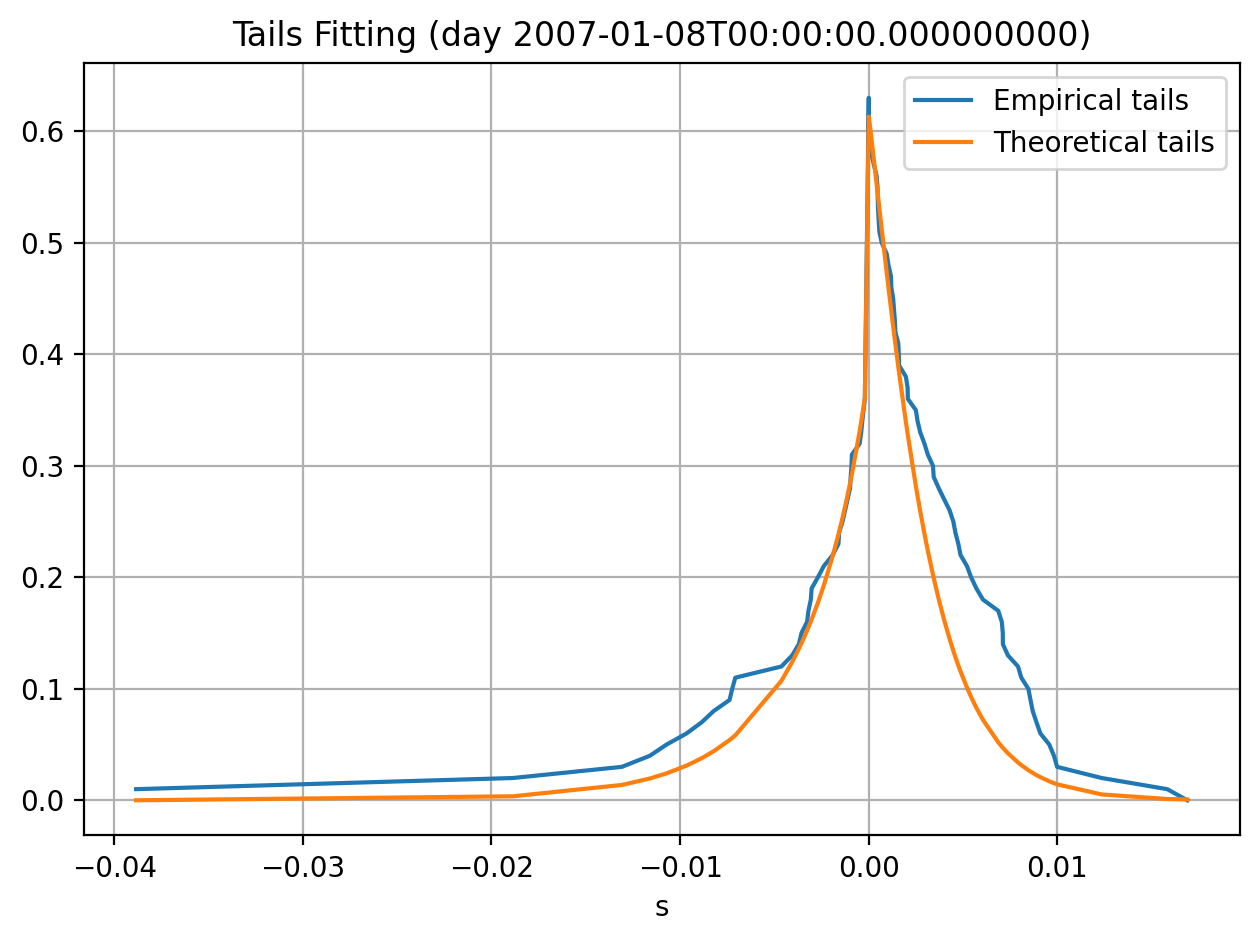

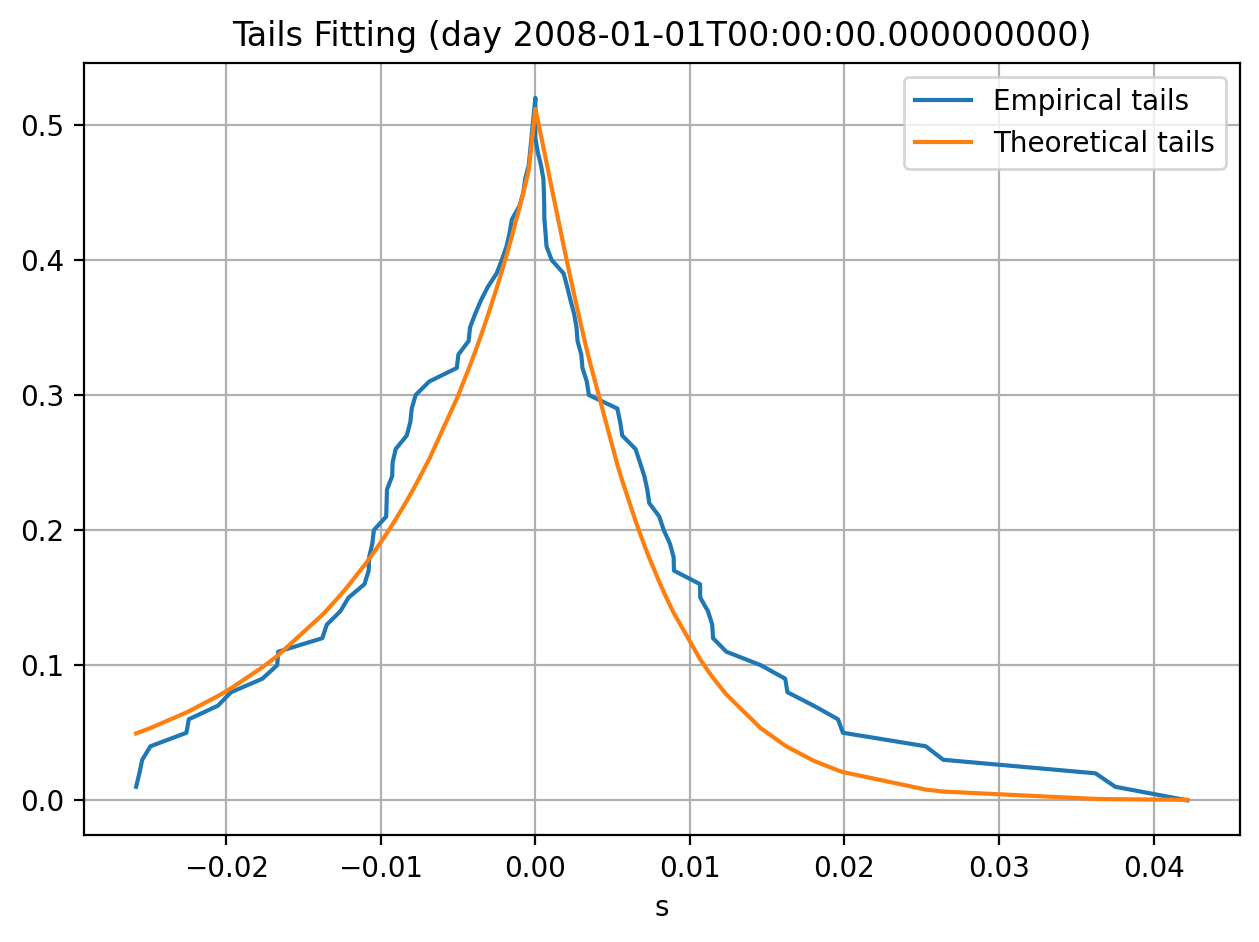

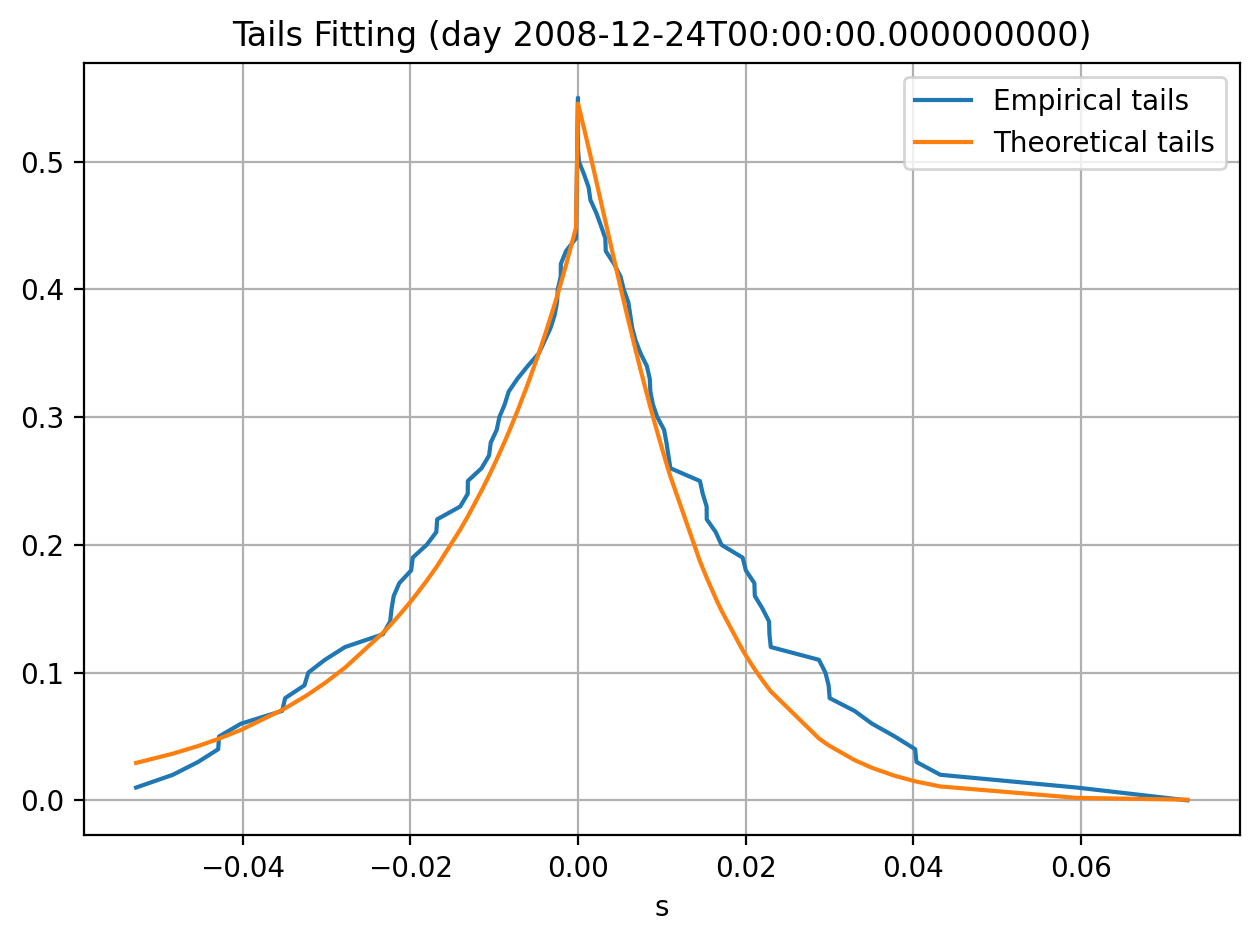

In [5]:
idx = [0,256,512]
figures = bg.plot_empirical_vs_theoretical(theta_spy=theta_spy, n=5, days=idx,returnfig=True)
for fig in figures:
    display(fig)

Average loss per day: 0.0373
Max loss per day: 0.1960
Day with max loss: 2014-07-24T00:00:00.000000000


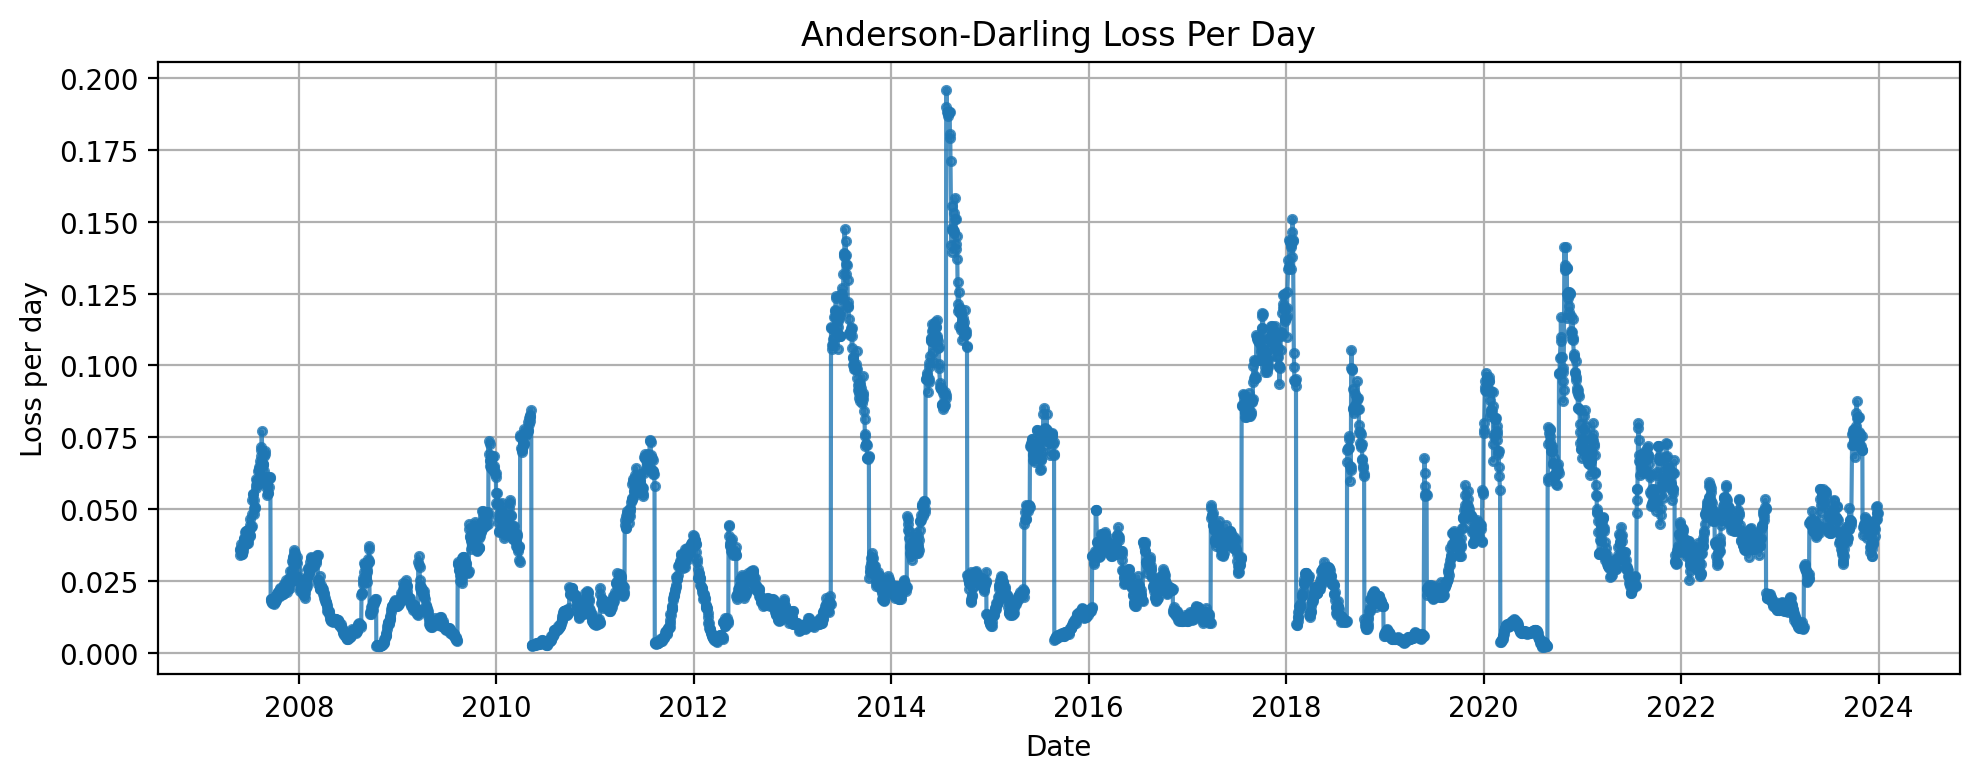

In [6]:
fig = bg.plot_loss_per_day(returnfig=True)
print(f"Average loss per day: {bg.batch_losses.mean():.4f}")
print(f"Max loss per day: {bg.batch_losses.max():.4f}")
print(f"Day with max loss: {bg.days[bg.fit_day_indices][bg.batch_losses.argmax()]}")

display(fig)

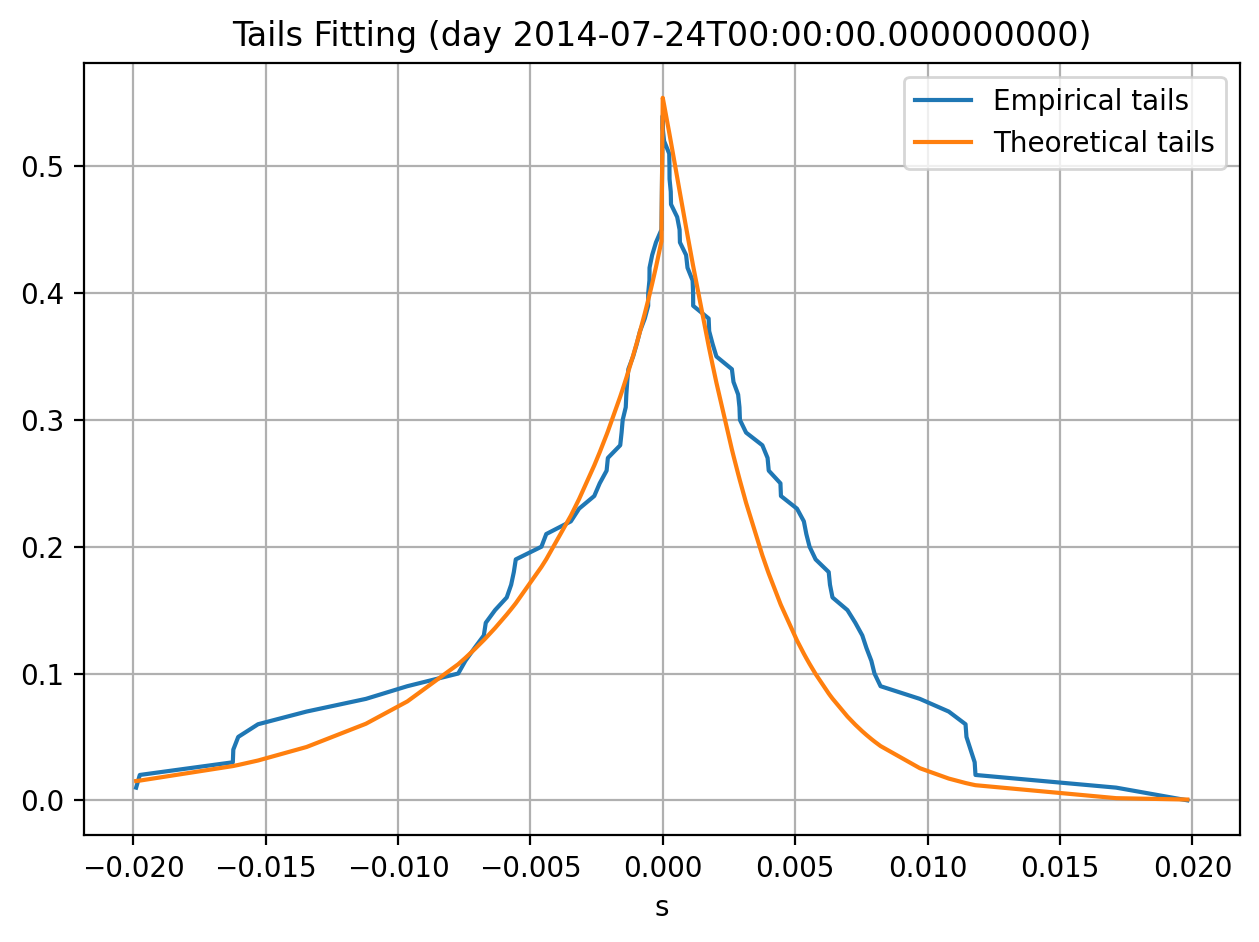

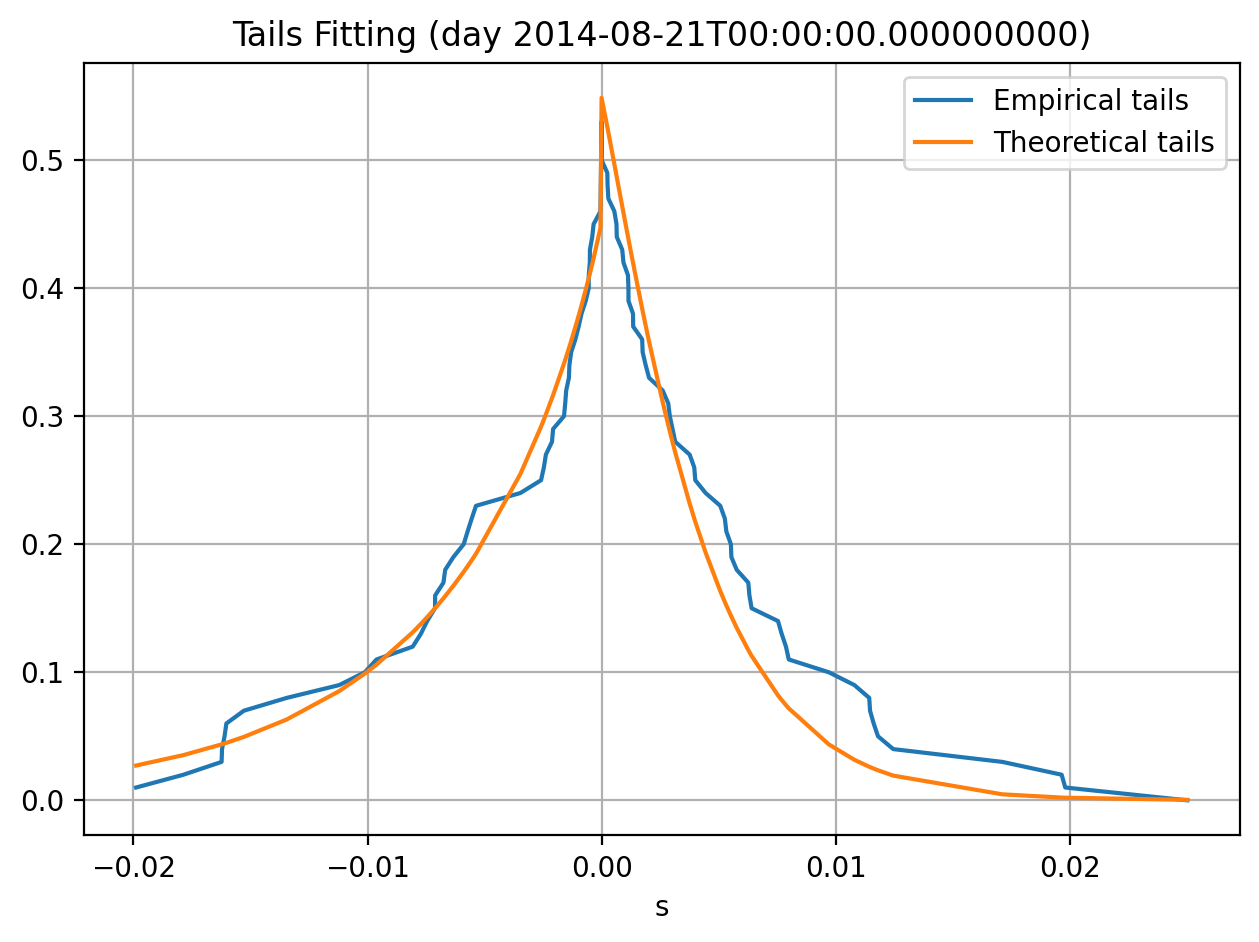

In [7]:
# Plot empirical vs theoretical quantiles for SPY on day with max loss
idx_worst = bg.batch_losses.argmax()+bg.window
idx = [idx_worst,idx_worst+20]
figures = bg.plot_empirical_vs_theoretical(theta_spy=theta_spy, n=2, days=idx, returnfig=True)
for fig in figures:
    display(fig)